In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import torch
import torch.nn as nn
from sklearn.metrics import recall_score
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# Đường dẫn
data_path = 'F:/dataML/data/TRX/output/TRX_28_27994440_20230324_144900_1174121.csv'

# Đọc dữ liệu
df = pd.read_csv(data_path)

# Chuyển đổi OpenTime thành datetime
df['OpenTime'] = pd.to_datetime(df['OpenTime'])

df.set_index('OpenTime', inplace=True)
df.sort_index(inplace=True) 


In [6]:
Y_TYPE = 'close_vs_maxhigh60_r10'

# Đếm số lượng bản ghi
count_rows = len(df)

# Đếm số lượng 0
count_zeros = (df[Y_TYPE] == 0).sum()

# Đếm số lượng 1
count_ones = (df[Y_TYPE] == 1).sum()

# In kết quả
print("Số lượng giá trị 0:", count_zeros)
print("Số lượng giá trị 1:", count_ones)
print("Số lượng bản ghi:", count_rows) 

Số lượng giá trị 0: 387672
Số lượng giá trị 1: 786449
Số lượng bản ghi: 1174121


TRỰC QUAN HÓA % CỦA GIÁ "CLOSE" VỚI MIN LOW VÀ MIN HIGH

In [7]:
# label_cols = [
#     'close_vs_minlow5',
#     'close_vs_minlow10',
#     'close_vs_minlow30',
#     'close_vs_minlow60',
#     'close_vs_maxhigh5',
#     'close_vs_maxhigh10',
#     'close_vs_maxhigh30',
#     'close_vs_maxhigh60'
# ]

# # Điều chỉnh kích thước figure 
# plt.figure(figsize=(15, 8))

# for i, col in enumerate(label_cols):
#     plt.subplot(2, 4, i + 1)  
#     sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False)
#     plt.title(f'Class balance: {col}')
#     plt.xlabel('Label')
#     plt.ylabel('Count')

# plt.tight_layout()
# plt.show()


In [8]:
df.isna().sum()

MinuteId                  0
Close                     0
StartCumulative           0
delta                     0
gain                      0
                         ..
close_vs_minlow60_r20     0
close_vs_maxhigh60_pct    0
close_vs_maxhigh60_r8     0
close_vs_maxhigh60_r10    0
close_vs_maxhigh60_r20    0
Length: 72, dtype: int64

In [9]:
# # 4. Kiểm tra tương quan
# features_corr= [
#     'Close', 
#     'EMA_9', 'EMA_25', 'EMA_50',
#     'SMA_9', 'SMA_25', 'SMA_50',
#     'RSI',
#     'MACD', 'MACD_signal', 'MACD_diff',
#     'SMA_MACD_diff_5', 'SMA_MACD_diff_10', 'SMA_MACD_diff_sub'
# ]

# correlation_matrix = df[features_corr].corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Matrix of Features')
# plt.show()

CHIA DỮ LIỆU 70% TRAIN, 20% VALIDATION, 10% TEST

In [10]:
features = [
    'sma_macd_diff_5',
    'sma_macd_diff_10', 
    'sma_macd_diff_sub',
    'macd_diff',
    'macd',
    'close_div_ema9',
    'close_div_ema25',
    'close_div_ema50',
    'close_div_sma9',
    'close_div_sma25',
    'close_div_sma50'
]

X = df[features]
y = df[Y_TYPE]

# Chia dữ liệu: 70% train, 20% val, 10% test
# Bước 1: Chia 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=False
)

# Bước 2: Chia 90% còn lại thành 77.8% train và 22.2% validation 
# (tương đương 70% và 20% của toàn bộ dữ liệu)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2222, random_state=42, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Hàm tạo dữ liệu sliding window cho mô hình LSTM
# X: dữ liệu đầu vào (numpy array hoặc mảng chuẩn hóa)
# y: nhãn đầu ra (dạng chuỗi nhị phân 0/1)
# lookback: số bước thời gian mà mô hình sẽ "nhìn lại"
def create_sliding_window(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        # Tạo 1 chuỗi gồm 'lookback' dòng liên tiếp của X
        Xs.append(X[i:i+lookback])
        # Nhãn tương ứng là dòng ngay sau chuỗi (dự đoán tương lai)
        ys.append(y[i+lookback])
    # Trả về mảng 3 chiều cho X và 1 chiều cho y
    return np.array(Xs), np.array(ys)

# Số bước nhìn lại (lookback) trong quá khứ, đơn vị: phút
lookback = 60

# Tạo tập huấn luyện theo sliding window
X_train_seq, y_train_seq = create_sliding_window(X_train_scaled, y_train.values, lookback)
X_val_seq, y_val_seq = create_sliding_window(X_val_scaled, y_val.values, lookback)
X_test_seq, y_test_seq = create_sliding_window(X_test_scaled, y_test.values, lookback)

# Kiểm tra kích thước đầu ra để xác minh kết quả
print("Train:", X_train_seq.shape, y_train_seq.shape)  # (số mẫu, lookback, số đặc trưng)
print("Val:", X_val_seq.shape, y_val_seq.shape)
print("Test:", X_test_seq.shape, y_test_seq.shape)


Train: (821847, 60, 11) (821847,)
Val: (234741, 60, 11) (234741,)
Test: (117353, 60, 11) (117353,)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [13]:
# Bước 0: Tính pos_weight

num_neg = torch.sum(torch.tensor(y_train_seq) == 0)
num_pos = torch.sum(torch.tensor(y_train_seq) == 1)
pos_weight_value = num_neg / num_pos  # hệ số bù class  
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)

In [14]:
# Bước 1: Chuyển dữ liệu sliding window sang tensor và đưa lên GPU (dùng X_train_seq thay vì X_train_scaled)
X_train_lstm = torch.tensor(X_train_seq, dtype=torch.float32).to(device)  # shape: (samples, lookback, features)
y_train_lstm = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1).to(device)  # shape: (samples, 1)

X_val_lstm = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_lstm = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1).to(device)

X_test_lstm = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_lstm = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1).to(device)

# Bước 2: Tạo Dataset & DataLoader
train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
val_dataset = TensorDataset(X_val_lstm, y_val_lstm)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)

    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.output(out)
        return out


In [16]:
model = LSTMModel(input_size=X_train_scaled.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
patience_counter = 0


In [17]:
for epoch in range(100):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_total_loss += loss.item()
    val_loss = val_total_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_lstm_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load mô hình tốt nhất
model.load_state_dict(torch.load("best_lstm_model.pth"))


Epoch 1, Train Loss: 0.4943, Val Loss: 0.4644
Epoch 2, Train Loss: 0.4943, Val Loss: 0.4639
Epoch 3, Train Loss: 0.4943, Val Loss: 0.4654
Epoch 4, Train Loss: 0.4943, Val Loss: 0.4638
Epoch 5, Train Loss: 0.4943, Val Loss: 0.4647
Epoch 6, Train Loss: 0.4942, Val Loss: 0.4646
Epoch 7, Train Loss: 0.4942, Val Loss: 0.4641
Epoch 8, Train Loss: 0.4942, Val Loss: 0.4636
Epoch 9, Train Loss: 0.4942, Val Loss: 0.4635
Epoch 10, Train Loss: 0.4942, Val Loss: 0.4636
Epoch 11, Train Loss: 0.4942, Val Loss: 0.4623
Epoch 12, Train Loss: 0.4943, Val Loss: 0.4637
Epoch 13, Train Loss: 0.4943, Val Loss: 0.4648
Epoch 14, Train Loss: 0.4943, Val Loss: 0.4649
Epoch 15, Train Loss: 0.4943, Val Loss: 0.4635
Epoch 16, Train Loss: 0.4942, Val Loss: 0.4630
Early stopping triggered.


C:\Users\ai2\AppData\Local\Temp\ipykernel_58736\2641402006.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_model.pth"))


<All keys matched successfully>

In [18]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_lstm)
    y_pred_prob = torch.sigmoid(y_pred).squeeze().cpu().numpy()  # Chuyển thành xác suất
    y_pred_label = (y_pred_prob > 0.5).astype(int)  # Ngưỡng trên xác suất

# Đảm bảo y_test là numpy array
y_test_arr = y_test_seq if isinstance(y_test_seq, np.ndarray) else y_test_seq.cpu().numpy()

# In độ chính xác
acc = accuracy_score(y_test_arr, y_pred_label) * 100
print(f"Độ chính xác của mô hình LSTM: {acc:.2f}%")

# Classification report dạng dict
report = classification_report(y_test_arr, y_pred_label, output_dict=True)

# Hàm định dạng phần trăm
def format_percent(value):
    return f"{value * 100:.2f}%"

# In báo cáo dạng phần trăm
print("\nBáo cáo phân loại (%):")
print(f"{'Label':<12} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'Support':>10}")
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label:<12} {format_percent(metrics['precision']):>10} {format_percent(metrics['recall']):>10} {format_percent(metrics['f1-score']):>10} {int(metrics['support']):>10}")
    elif label == "accuracy":
        print(f"{label:<12} {'-':>10} {'-':>10} {format_percent(metrics):>10} {int(report['macro avg']['support']):>10}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 35.78 GiB. GPU 0 has a total capacity of 8.00 GiB of which 1.88 GiB is free. Of the allocated memory 4.99 GiB is allocated by PyTorch, and 48.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

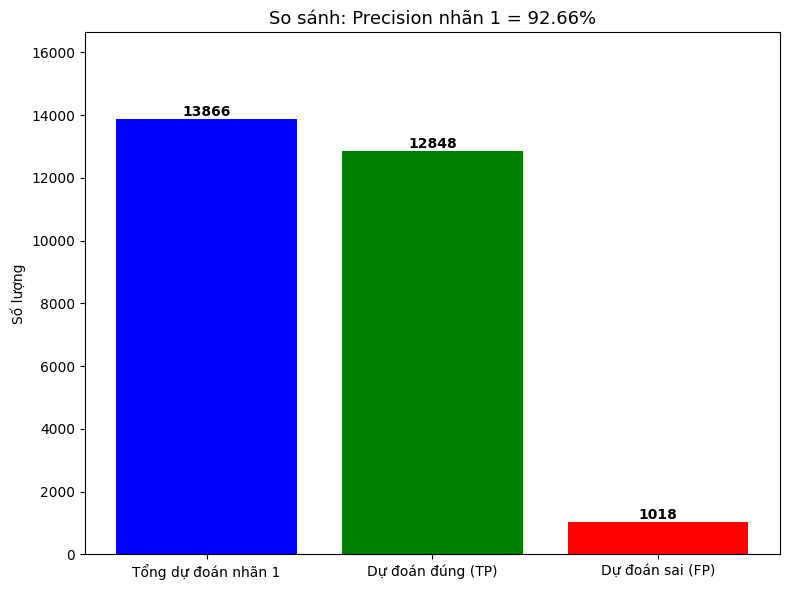

In [ ]:
# === Tính toán precision cho nhãn 1 ===
tp_1 = np.sum((y_test_arr == 1) & (y_pred_label == 1))  # True Positive
fp_1 = np.sum((y_test_arr == 0) & (y_pred_label == 1))  # False Positive
total_predicted_1 = tp_1 + fp_1                         # Tổng dự đoán là nhãn 1

# Tính precision
if total_predicted_1 == 0:
    print("⚠️ Cảnh báo: Mô hình không dự đoán bất kỳ nhãn 1 nào.")
    precision_1 = 0
else:
    precision_1 = tp_1 / total_predicted_1

# === Dữ liệu biểu đồ ===
labels = ['Tổng dự đoán nhãn 1', 'Dự đoán đúng (TP)', 'Dự đoán sai (FP)']
values = [total_predicted_1, tp_1, fp_1]
colors = ['blue', 'green', 'red']

# === Vẽ biểu đồ ===
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

# Gắn nhãn lên đầu cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tiêu đề biểu đồ
plt.title(f'So sánh: Precision nhãn 1 = {precision_1 * 100:.2f}%', fontsize=13)
plt.ylabel('Số lượng')
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()


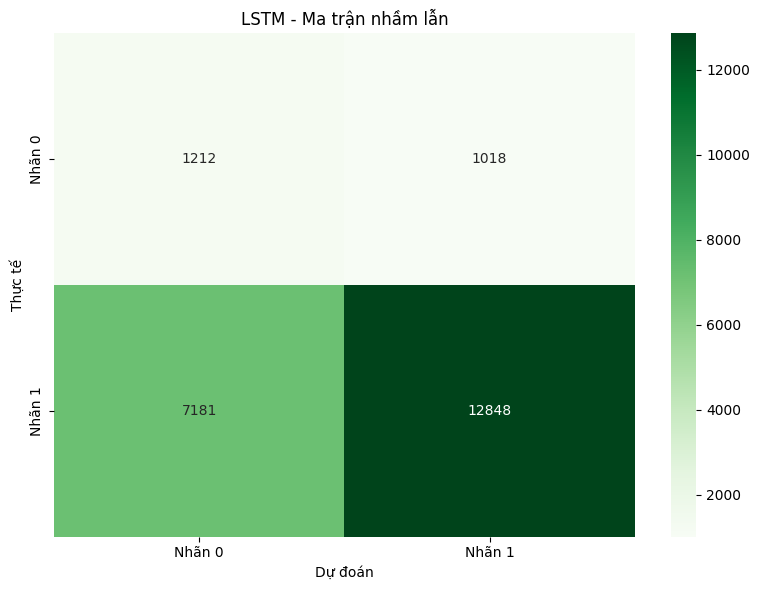

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tính confusion matrix
cm_lstm = confusion_matrix(y_test_arr, y_pred_label)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Nhãn 0', 'Nhãn 1'],
            yticklabels=['Nhãn 0', 'Nhãn 1'])

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('LSTM - Ma trận nhầm lẫn')
plt.tight_layout()
plt.show()


Recall nhãn 1 ban đầu: 0.64


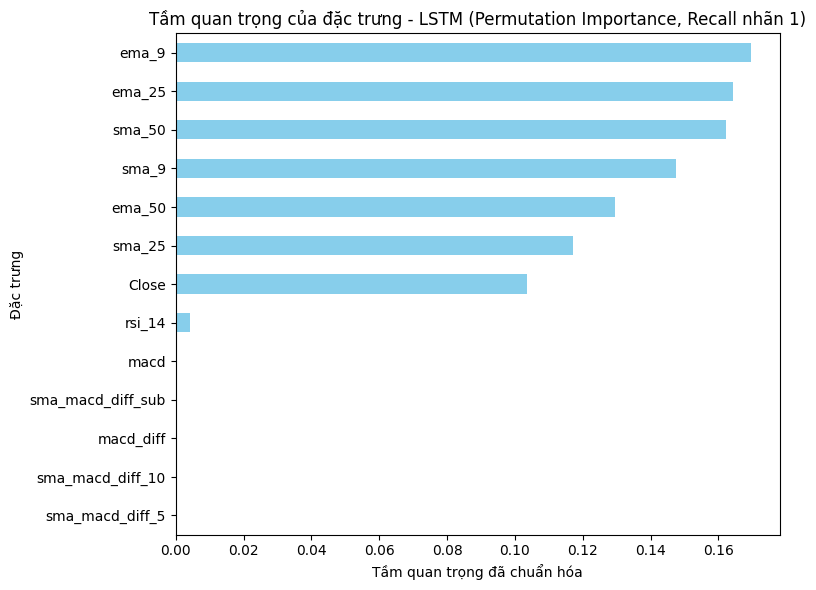

In [ ]:
# Bước 1: Tính recall ban đầu
model.eval()
with torch.no_grad():
    y_pred_base = torch.sigmoid(model(X_test_lstm)).squeeze().cpu().numpy()
    y_pred_base_label = (y_pred_base > 0.5).astype(int)
base_recall = recall_score(y_test_arr, y_pred_base_label, pos_label=1)
print(f"Recall nhãn 1 ban đầu: {base_recall:.2f}")

# Bước 2: Hàm tính permutation importance
def compute_permutation_importance(model, X_base, y_true, base_score, device, n_repeats=5):
    importance_scores = np.zeros(X_base.shape[2])
    for i in range(X_base.shape[2]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_base.clone()
            idx = torch.randperm(X_permuted.shape[0])
            X_permuted[:, :, i] = X_permuted[idx, :, i]
            with torch.no_grad():
                y_pred = torch.sigmoid(model(X_permuted)).squeeze().cpu().numpy()
                y_pred_label = (y_pred > 0.5).astype(int)
            score = recall_score(y_true, y_pred_label, pos_label=1)
            scores.append(base_score - score)
        importance_scores[i] = np.mean(scores)
    return importance_scores

# Bước 3: Tính và chuẩn hóa tầm quan trọng
importances = compute_permutation_importance(model, X_test_lstm, y_test_arr, base_recall, device)
if importances.sum() == 0:
    normalized_importance = np.zeros_like(importances)
else:
    normalized_importance = np.abs(importances) / np.abs(importances).sum()

# Bước 4: Vẽ biểu đồ
features = ['sma_macd_diff_5', 'sma_macd_diff_10', 'sma_macd_diff_sub', 'macd_diff', 'macd', 
            'rsi_14', 'ema_9', 'ema_25', 'ema_50', 'sma_9', 'sma_25', 'sma_50', 'Close']
lstm_importance = pd.Series(normalized_importance, index=features).sort_values()
plt.figure(figsize=(8, 6))
lstm_importance.plot(kind='barh', color='skyblue')
plt.title('Tầm quan trọng của đặc trưng - LSTM (Permutation Importance, Recall nhãn 1)')
plt.xlabel('Tầm quan trọng đã chuẩn hóa')
plt.ylabel('Đặc trưng')
plt.tight_layout()
plt.show()

In [ ]:
# ========================================
# Bước 1: Đọc dữ liệu test mới
# ========================================
df_test_new = pd.read_csv("F:/dataML/data/TRX/TRX_2025-06-17_07-15-45.csv")

# Nếu có nhãn thật thì tách ra
if Y_TYPE in df_test_new.columns:
    y_test_new = df_test_new[Y_TYPE].values
    X_test_new = df_test_new.drop(columns=[Y_TYPE])
else:
    y_test_new = None
    X_test_new = df_test_new.copy()

# Đảm bảo đúng thứ tự cột
X_test_new = X_test_new[features]

# ========================================
# Bước 2: Scale giống như train
# ========================================
X_test_new_scaled = scaler.transform(X_test_new)

# ========================================
# Bước 3: Tạo sliding window
# ========================================
def create_sliding_window_only_X(X, lookback):
    Xs = []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
    return np.array(Xs)

X_test_new_seq = create_sliding_window_only_X(X_test_new_scaled, lookback)

# Cắt nhãn tương ứng nếu có
if y_test_new is not None:
    y_test_new_seq = y_test_new[lookback:]
else:
    y_test_new_seq = None

# ========================================
# Bước 4: Dự đoán
# ========================================
X_test_new_lstm = torch.tensor(X_test_new_seq, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    y_pred_new_prob = torch.sigmoid(model(X_test_new_lstm)).squeeze().cpu().numpy()
    y_pred_new = (y_pred_new_prob > 0.5).astype(int)

# ========================================
# Bước 5: Đánh giá hoặc hiển thị
# ========================================
if y_test_new_seq is not None:
    print(classification_report(y_test_new_seq, y_pred_new))
else:
    print("✅ Dự đoán hoàn tất. Hiển thị 10 kết quả đầu tiên:")
    print(y_pred_new[:10])


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1569
           1       0.66      1.00      0.80      3066

    accuracy                           0.66      4635
   macro avg       0.33      0.50      0.40      4635
weighted avg       0.44      0.66      0.53      4635



c:\Users\ai1\Desktop\Model\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ai1\Desktop\Model\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ai1\Desktop\Model\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


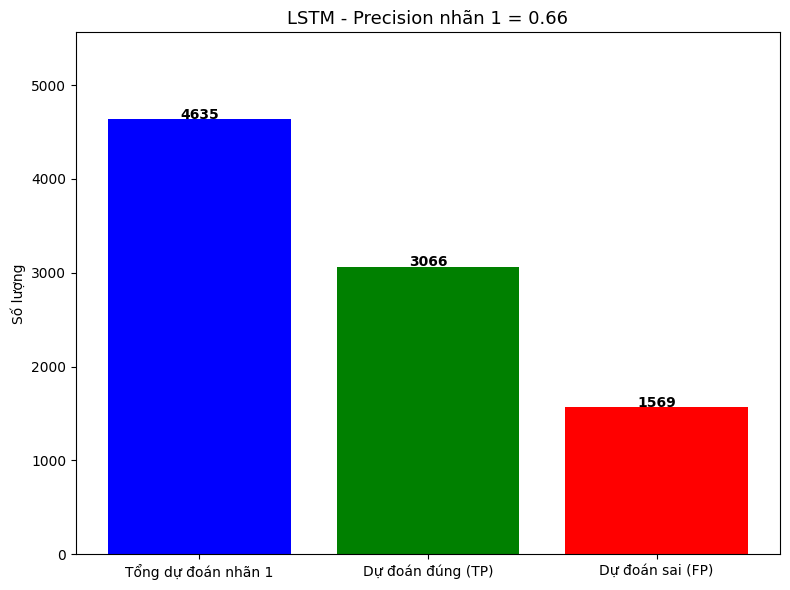

In [ ]:
# === Tính Precision nhãn 1 ===
tp_1 = np.sum((y_test_new_seq == 1) & (y_pred_new == 1))  # True Positive
fp_1 = np.sum((y_test_new_seq == 0) & (y_pred_new == 1))  # False Positive
total_predicted_1 = tp_1 + fp_1

if total_predicted_1 == 0:
    print("⚠️ Cảnh báo: Mô hình không dự đoán bất kỳ nhãn 1 nào.")
    precision_1 = 0
else:
    precision_1 = tp_1 / total_predicted_1
    
# === Dữ liệu cho biểu đồ ===
labels = ['Tổng dự đoán nhãn 1', 'Dự đoán đúng (TP)', 'Dự đoán sai (FP)']
values = [total_predicted_1, tp_1, fp_1]
colors = ['blue', 'green', 'red']

# === Vẽ biểu đồ Precision ===
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{height}', ha='center', fontsize=10, fontweight='bold')

plt.title(f'LSTM - Precision nhãn 1 = {precision_1:.2f}', fontsize=13)
plt.ylabel('Số lượng')
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()


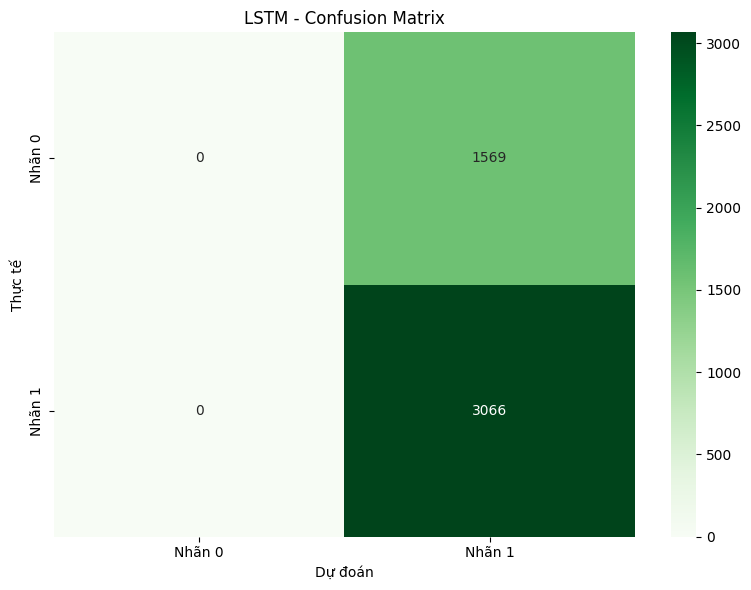

In [ ]:
# === Ma trận nhầm lẫn ===
cm_lstm = confusion_matrix(y_test_new_seq, y_pred_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Nhãn 0', 'Nhãn 1'],
            yticklabels=['Nhãn 0', 'Nhãn 1'])

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('LSTM - Confusion Matrix')
plt.tight_layout()
plt.show()
